In [1]:
import django, sys, os
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()


import shapely
import shapely.vectorized

from scoping.models import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import product, combinations
from utils.text import *
from pycountry_convert import  country_alpha2_to_continent_code, country_alpha3_to_country_alpha2
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy
import geopy
import geopy.distance

import cartopy.io.shapereader as shpreader


import pandas as pd

In [2]:
df = pd.read_csv('../data/category_predictions.csv')
df.head()

,Unnamed: 0,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant,12 - Coastal and marine Ecosystems,...,6 - Water availability - k_prediction,6 - Water availability - k_prediction_binary,6 - Temperature - mean_prediction,6 - Temperature - std_prediction,6 - Temperature - lower_pred,6 - Temperature - upper_pred,6 - Precipitation - mean_prediction,6 - Precipitation - std_prediction,6 - Precipitation - lower_pred,6 - Precipitation - upper_pred
0,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1284614,Tree-ring width chronologies from the upper ti...,Separating temperature from precipitation sign...,Northeastern Tibetan Plateau; Tree-ring width;...,"['Geography, Physical; Geosciences, Multidisci...",0.0,0.0,0.0,0.0,...,NaN,NaN,1.000000,0.000000,1.0,1.000000,0.333333,0.471405,0.0,0.804738
2,2,1344242,This study examines the spatial and temporal p...,GIS analysis of spatial and temporal patterns ...,fire; geographic information systems; manageme...,['Forestry'],0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,289649,"Permafrost, mainly of discontinuous type, that...","Thermokarst lake, hydrological flow and water ...",Permafrost; Thermokarst lakes; Hydrological cy...,"['Engineering, Civil; Geosciences, Multidiscip...",0.0,0.0,0.0,0.0,...,NaN,NaN,0.166667,0.372678,0.0,0.539345,1.000000,0.000000,1.0,1.000000
4,4,399966,"Since 2005, Morocco has designated 28 Importan...",Factors Influencing Species-Richness of Breedi...,Breeding waterfowl; Diversity; Spatial scale; ...,['Ecology; Environmental Sciences'],0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
geos = pd.read_csv('../data/geo_df.csv')
geos = geos.drop_duplicates(["doc_id","geonameid"])
print(geos.shape)
geos.head()

(105576, 9)


,admin1,lat,lon,country_code3,geonameid,place_name,feature_class,feature_code,doc_id
0,NaN,39.76000,-98.5000,USA,6252001,United States,A,PCLI,3305893
1,NaN,22.00000,79.0000,IND,1269750,Republic of India,A,PCLI,1477550
2,NaN,60.00000,100.0000,RUS,2017370,Russian Federation,A,PCLI,1477550
3,Punjab,31.47060,74.3488,PAK,7043356,Pakistan Foundation Technical Institute,S,SCHC,1477550
4,NaN,3.51342,-132.1875,NaN,2363254,Pacific Ocean,H,OCN,1477550


In [4]:
from operator import itemgetter
import ast

places = pd.read_csv('../data/place_df.csv')
places = places[places['country_conf']>0.8]
places = places[pd.notnull(places["geo"])]
def extract_geo(df,l):
    return zip(*[itemgetter(*l)(ast.literal_eval(x.replace("nan",'""'))) for x in places.geo])
places['lat'], places['lon'], places['feature_code'] = extract_geo(places, ["lat","lon","feature_code"])
places.lat = places.lat.astype(float)
places.lon = places.lon.astype(float)
#places = places[places["feature_code"]!="PCLI"]
places.head()

,Unnamed: 0,word,spans,country_predicted,country_conf,geo,doc_id,lat,lon,feature_code
0,0,United States,"[{'start': 427, 'end': 440}]",USA,0.999811,"{'admin1': 'NA', 'lat': '39.76', 'lon': '-98.5...",3305893,39.7600,-98.5000,PCLI
3,3,India,"[{'start': 140, 'end': 145}]",IND,0.999398,"{'admin1': 'NA', 'lat': '22', 'lon': '79', 'co...",1477550,22.0000,79.0000,PCLI
4,4,Russia,"[{'start': 697, 'end': 703}]",RUS,0.999401,"{'admin1': 'NA', 'lat': '60', 'lon': '100', 'c...",1477550,60.0000,100.0000,PCLI
5,5,Pakistan,"[{'start': 763, 'end': 771}]",PAK,0.989610,"{'admin1': 'Punjab', 'lat': '31.4706', 'lon': ...",1477550,31.4706,74.3488,SCHC
7,7,Russia,"[{'start': 983, 'end': 989}]",RUS,0.999401,"{'admin1': 'NA', 'lat': '60', 'lon': '100', 'c...",1477550,60.0000,100.0000,PCLI


In [5]:
df_places = pd.merge(df,places,left_on="id",right_on="doc_id")
df_places.head()

,Unnamed: 0_x,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant,12 - Coastal and marine Ecosystems,...,Unnamed: 0_y,word,spans,country_predicted,country_conf,geo,doc_id,lat,lon,feature_code
0,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,86174,China,"[{'start': 157, 'end': 162}]",CHN,0.999764,"{'admin1': 'NA', 'lat': '35', 'lon': '105', 'c...",136746,35.00,105.00,PCLI
1,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,86175,Qinghai,"[{'start': 1777, 'end': 1784}]",CHN,0.993103,"{'admin1': 'Qinghai', 'lat': '36', 'lon': '96'...",136746,36.00,96.00,ADM1
2,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,86176,Inner Mongolia,"[{'start': 1786, 'end': 1800}]",CHN,0.993103,"{'admin1': 'Inner Mongolia', 'lat': '43.5', 'l...",136746,43.50,114.75,ADM1
3,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,86177,Xinjiang,"[{'start': 1806, 'end': 1814}]",CHN,0.993103,{'admin1': 'Xinjiang Uyghur Autonomous Region'...,136746,41.50,85.50,ADM1
4,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,86178,Gansu,"[{'start': 1922, 'end': 1927}]",CHN,0.993103,"{'admin1': 'Gansu', 'lat': '37.75', 'lon': '10...",136746,37.75,102.75,ADM1


# density

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


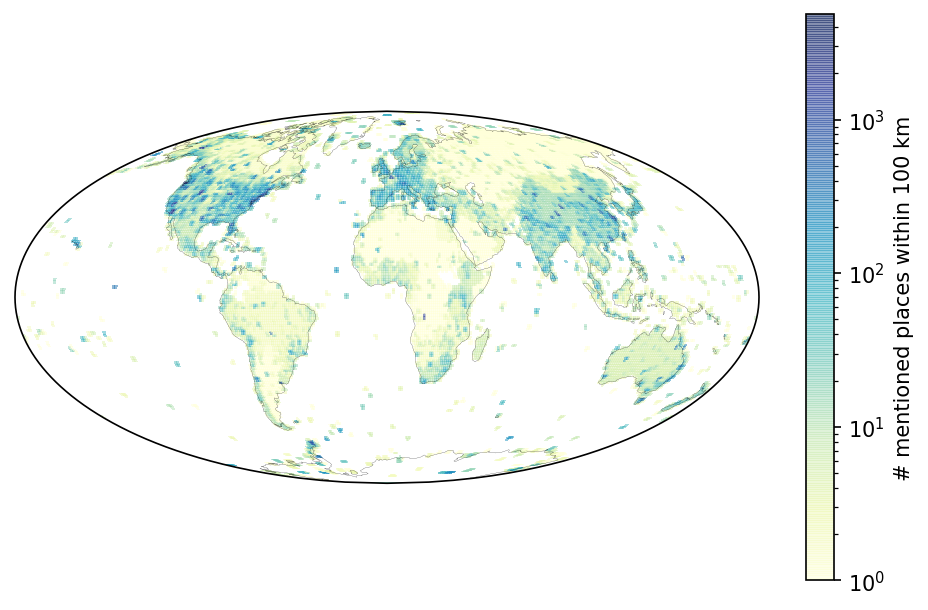

In [116]:
fig, ax = plt.subplots(dpi=150, figsize=(8,5))

p = ccrs.Mollweide()
#p = ccrs.PlateCarree()

ax = plt.axes(projection=p)
ax.set_global()
ax.coastlines(lw=0.1)

vm = n[~np.isnan(n)].max()

n[n == 0] = np.nan

pcm = plt.pcolormesh( 
    lonbins, latbins, n,
    transform=ccrs.PlateCarree(),
    norm=mpl.colors.LogNorm(vmin=1, vmax=vm),
    alpha=0.5,
    cmap="YlGnBu"
)

cbar = fig.colorbar(pcm)
cbar.set_label("# mentioned places within 100 km")

plt.savefig(f'../plots/maps/predicted_places_all_density.png',dpi=500)
plt.savefig(f'../plots/maps/predicted_places_all_density.pdf')

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


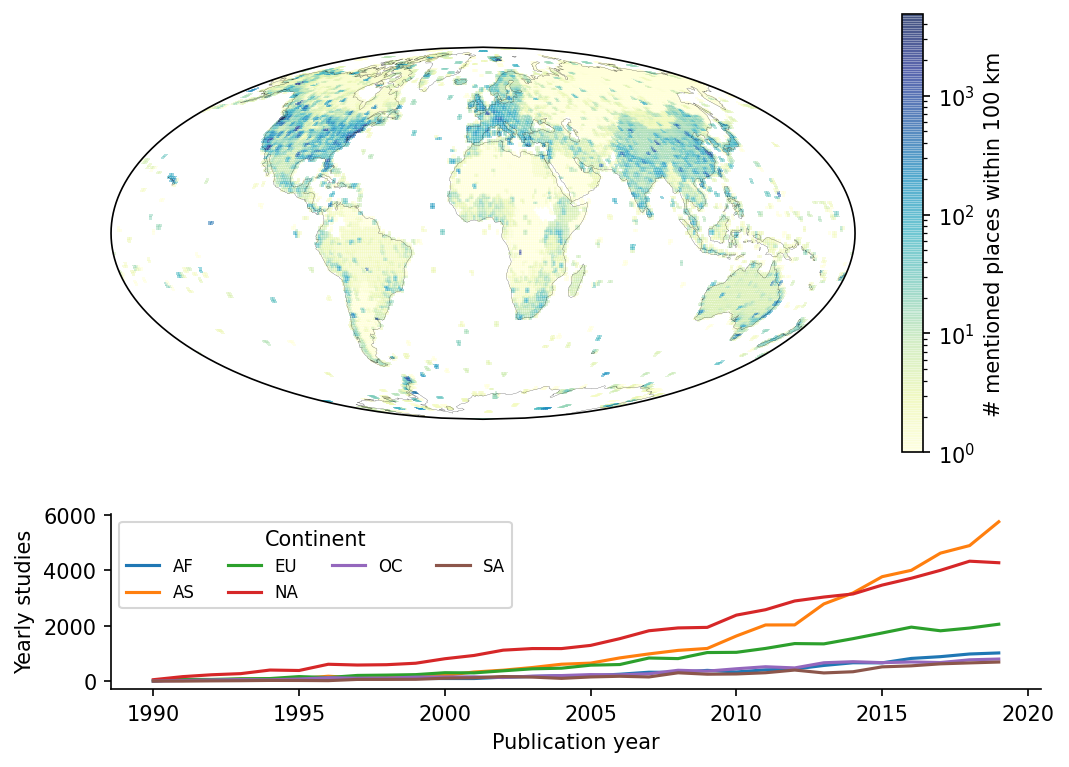

In [125]:
import matplotlib.gridspec as gridspec
fig = plt.figure(dpi=150,figsize=(8,5))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .4,], bottom=.05, top=.95, wspace=.1)
ax1 = plt.subplot(gs[0, 0], projection=ccrs.Mollweide())
ax1.set_global()
ax1.coastlines(lw=0.1)
pcm = plt.pcolormesh( 
    lonbins, latbins, n,
    transform=ccrs.PlateCarree(),
    norm=mpl.colors.LogNorm(vmin=1, vmax=vm),
    alpha=0.5,
    cmap="YlGnBu"
)

cbar = fig.colorbar(pcm)
cbar.set_label("# mentioned places within 100 km")

ax2 = plt.subplot(gs[1,0])
for name, group in pdf.groupby('continent'):
    lobj, = ax2.plot(group['PY'],group['N studies'],label=name)
ax2.legend(ncol=4,fontsize=8,loc="upper left",title="Continent")
#ax2.legend(ncol=4,fontsize=8)
ax2.set_ylabel("Yearly studies")
ax2.set_xlabel("Publication year")
sns.despine(ax=ax2)

fig.tight_layout()

plt.savefig(f'../plots/maps/predicted_places_all_density_panel.png',dpi=250,bbox_inches="tight")
plt.savefig(f'../plots/maps/predicted_places_all_density_panel.pdf',bbox_inches="tight")
            
plt.show()

In [8]:
import pycountry_convert as pc
def get_cont(x):
    try:
        return pc.country_alpha2_to_continent_code(pc.country_alpha3_to_country_alpha2(x['country_predicted']))
    except:
        return None
df_places['continent'] = df_places.apply(lambda x: get_cont(x), axis=1)

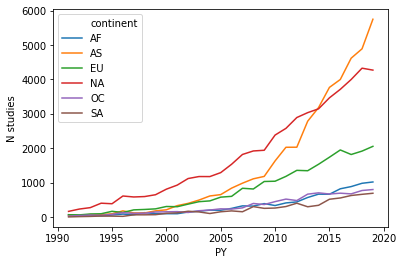

In [50]:
fig, ax = plt.subplots()
pdf = (df_places.groupby(['PY','continent'])['id']
       .aggregate("count")
       .reset_index()
       .query('PY<2020')
       .query('continent!="AN"')
       .query('PY>1990')
       .rename(columns={"id":"N studies"})
      )
pdf.head()

import seaborn as sns
sns.lineplot("PY","N studies",hue="continent",data=pdf,ax=ax)


In [64]:

pdf = (df_places.groupby(['PY','continent'])['id']
       .aggregate("count")
       .reset_index()
       .query('PY<2020')
       .query('continent!="AN"')
       .query('PY>=1990')
       .rename(columns={"id":"N studies"})
      )
pdf['cumsum'] = pdf.groupby('continent')['N studies'].transform(pd.Series.cumsum)
pdf.head()




,PY,continent,N studies,cumsum
10,1990.0,AF,6,6
11,1990.0,EU,6,6
12,1990.0,NA,54,54
13,1990.0,OC,3,3
14,1990.0,SA,4,4


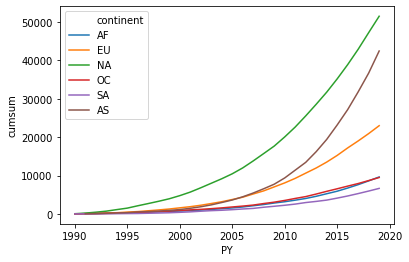

In [65]:
fig, ax = plt.subplots()
import seaborn as sns
sns.lineplot("PY","cumsum",hue="continent",data=pdf,ax=ax)

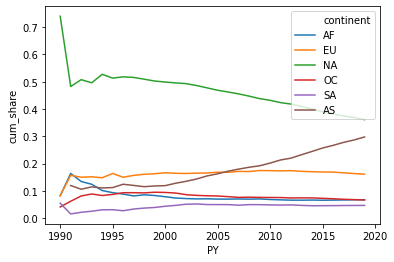

In [111]:
pdf['cum_share'] = pdf['cumsum'] / pdf.groupby('PY')['cumsum'].transform('sum')
fig, ax = plt.subplots()
import seaborn as sns
sns.lineplot("PY","cum_share",hue="continent",data=pdf,ax=ax)

calculating density grid of size: 64800
done


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


calculating density grid of size: 64800
done
(5, 5)
calculating density grid of size: 64800
done
(5, 5)
calculating density grid of size: 64800
done
(11, 5)
calculating density grid of size: 64800
done
(17, 5)
calculating density grid of size: 64800
done
(23, 5)
calculating density grid of size: 64800
done
(29, 5)
calculating density grid of size: 64800
done
(35, 5)
calculating density grid of size: 64800
done
(41, 5)
calculating density grid of size: 64800
done
(47, 5)
calculating density grid of size: 64800
done
(53, 5)
calculating density grid of size: 64800
done
(59, 5)
calculating density grid of size: 64800
done
(65, 5)
calculating density grid of size: 64800
done
(71, 5)
calculating density grid of size: 64800
done
(77, 5)
calculating density grid of size: 64800
done
(83, 5)
calculating density grid of size: 64800
done
(89, 5)
calculating density grid of size: 64800
done
(95, 5)
calculating density grid of size: 64800
done
(101, 5)
calculating density grid of size: 64800
done
(1

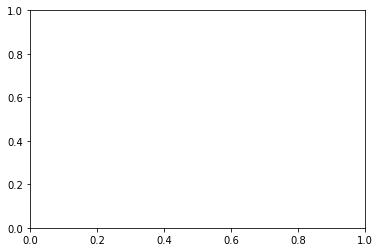

calculating density grid of size: 64800
done
(5, 5)


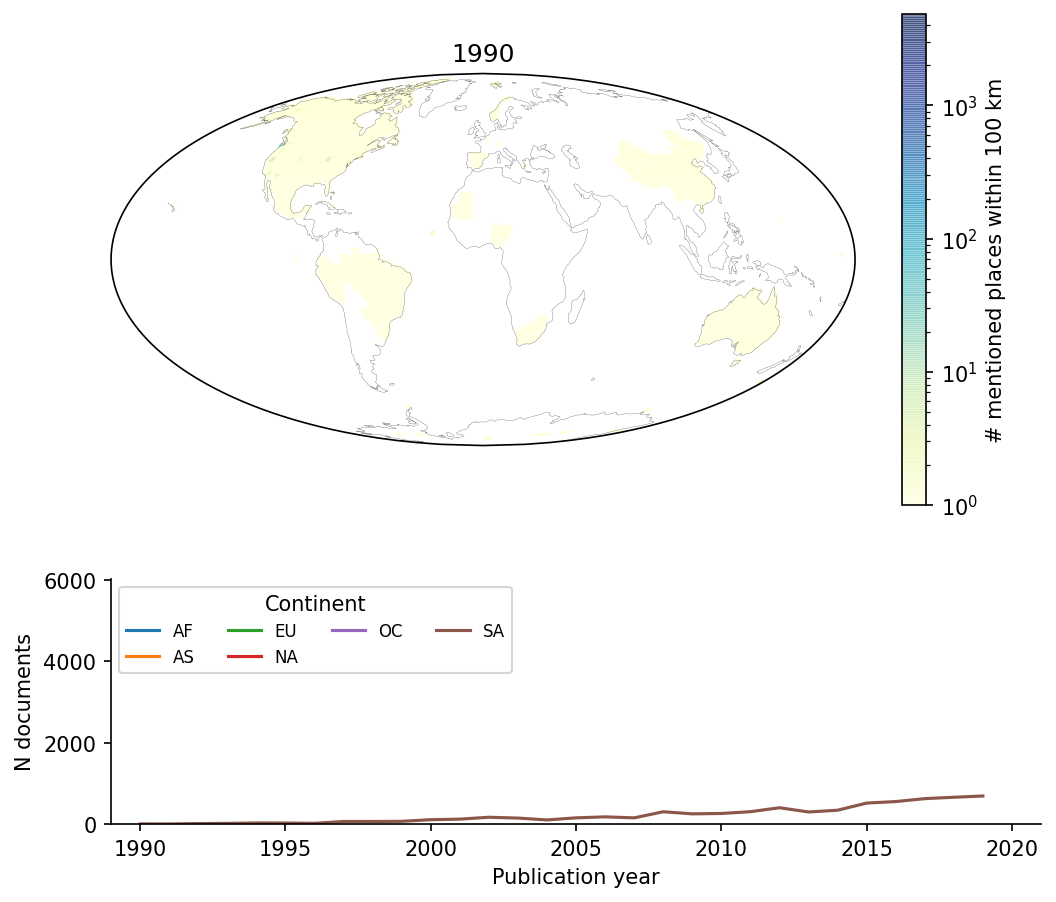

In [112]:
fig, ax = plt.subplots()
import matplotlib.animation as animation

latbins, lonbins, n = density_grid(1,100,df_places[df_places['PY']==1990])

fig = plt.figure(dpi=150,figsize=(8,6))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .5,], bottom=.05, top=.95, wspace=.1)
ax1 = plt.subplot(gs[0, 0], projection=ccrs.Mollweide())
ax1.set_global()
ax1.coastlines(lw=0.1)
pcm = plt.pcolormesh( 
    lonbins, latbins, n,
    transform=ccrs.PlateCarree(),
    norm=mpl.colors.LogNorm(vmin=1, vmax=vm),
    alpha=0.5,
    cmap="YlGnBu"
)

cbar = fig.colorbar(pcm)
cbar.set_label("# mentioned places within 100 km")

ax2 = plt.subplot(gs[1,0])
ax2.set_xlim([1989,2021])
ax2.set_ylim(ymax=pdf['N studies'].max()*1.05)
#line = sns.lineplot("PY","N studies",hue="continent",data=pdf,ax=ax2,lw=1)
#line, = ax2.plot(pdf['PY'],pdf['N studies'])
lines = []
for name, group in pdf.groupby('continent'):
    #lobj, = ax2.plot(group['PY'],group['N studies'])
    lobj, = ax2.plot([],[],label=name)
    lines.append(lobj)
ax2.legend(ncol=4,fontsize=8,loc="upper left",title="Continent")
ax2.set_xlabel("Publication year")
ax2.set_ylabel("N documents")
sns.despine(ax=ax2)
fig.tight_layout()

def init():
    pcm.set_array([])
    for line in lines:
        line.set_data([])
    return pcm, lines

def animate(i):
    sdf = df_places[df_places['PY']<=1990+i]  
    ax1.set_title(1990+i)
    latbins, lonbins, n = density_grid(1,100,sdf)
    pcm.set_array(n[:-1,:-1].ravel())    
    spdf = pdf[pdf['PY']<=1990+i]
    print(spdf.shape)
    for i, (name, group) in enumerate(spdf.groupby('continent')):
        lines[i].set_data(group['PY'],group['N studies'])
    return pcm, lines

#ani = animation.FuncAnimation(fig, animate, frames=3, repeat=False)#, blit = True)
ani = animation.FuncAnimation(fig, animate, frames=2020-1990, repeat=False)
ani.save('../plots/maps/animation.gif', writer='imagemagick', fps=2)

plt.show()


In [91]:
lines

In [ ]:
latbins, lonbins, n = density_grid(1,100,df_places)
vm = n[~np.isnan(n)].max()
p = ccrs.Mollweide()

for y in range(1990,2021):
    fig, ax = plt.subplots(dpi=150, figsize=(8,5))
    sdf = df_places[df_places['PY']<=y]  
    latbins, lonbins, n = density_grid(1,100,sdf)

    ax = plt.axes(projection=p)
    ax.set_global()
    ax.coastlines(lw=0.1)

    n[n == 0] = np.nan

    pcm = plt.pcolormesh( 
        lonbins, latbins, n,
        transform=ccrs.PlateCarree(),
        norm=mpl.colors.LogNorm(vmin=1, vmax=vm),
        alpha=0.5,
        cmap="YlGnBu"
    )
    
    ax.set_title(y)

    fig.colorbar(pcm)

    plt.savefig(f'../plots/maps/years/predicted_places_all_{y}_density.png',dpi=250)
    
    plt.show()

calculating density grid of size: 64800
done


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


calculating density grid of size: 64800
done
calculating density grid of size: 64800
done
calculating density grid of size: 64800
done
calculating density grid of size: 64800
done
calculating density grid of size: 64800
done


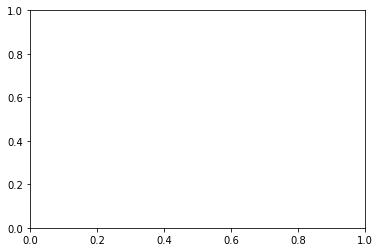

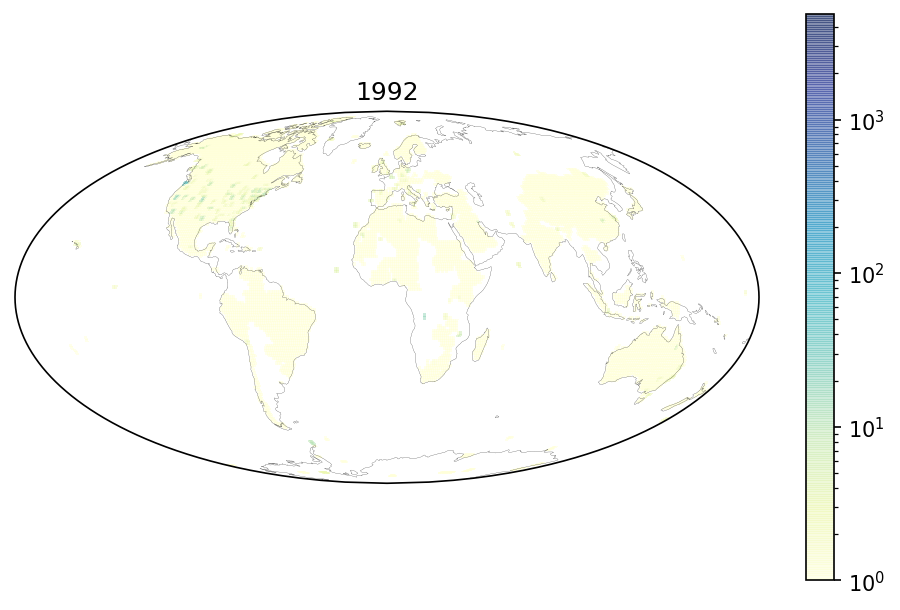

In [59]:
fig, ax = plt.subplots()
import matplotlib.animation as animation

latbins, lonbins, n = density_grid(1,100,df_places[df_places['PY']==1990])

fig, ax = plt.subplots(dpi=150, figsize=(8,5))

ax = plt.axes(projection=p)
ax.set_global()
ax.coastlines(lw=0.1)

n[n == 0] = np.nan

pcm = plt.pcolormesh( 
    lonbins, latbins, n,
    transform=ccrs.PlateCarree(),
    norm=mpl.colors.LogNorm(vmin=1, vmax=vm),
    alpha=0.5,
    cmap="YlGnBu"
)

fig.colorbar(pcm)
cbar.set_label("# mentioned places within 100 km")

def init():
    pcm.set_array([])
    return pcm

def animate(i):
    sdf = df_places[df_places['PY']<=1990+i]  
    ax.set_title(1990+i)
    latbins, lonbins, n = density_grid(1,100,sdf)
    pcm.set_array(n[:-1,:-1].ravel())
    return pcm,

ani = animation.FuncAnimation(fig, animate, frames=3, repeat=False, blit = True)
#ani = animation.FuncAnimation(fig, animate, frames=2020-1990, repeat=False, blit = True)
ani.save('../plots/maps/animation.gif', writer='imagemagick', fps=2)

plt.show()


Traceback (most recent call last):
  File "/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/matplotlib/animation.py", line 951, in _start
    self._init_draw()
  File "/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/matplotlib/animation.py", line 1743, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/matplotlib/animation.py", line 1766, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
TypeError: myanimate() argument after * must be an iterable, not GeoAxesSubplot


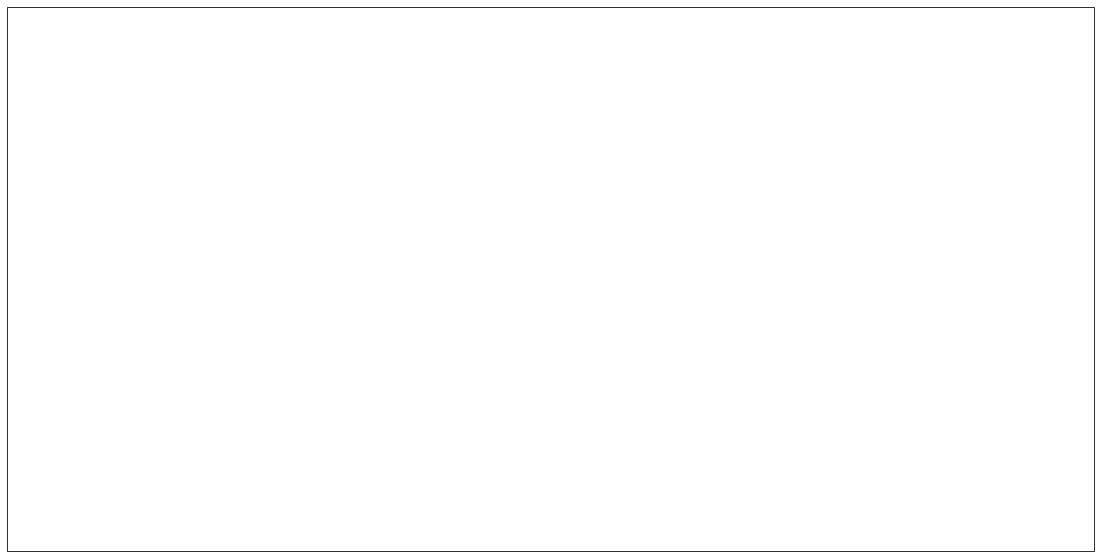

In [59]:
def drawmap(n, title):
    plt.pcolormesh(
        lonbins, latbins, n,
        transform=ccrs.PlateCarree(),
        norm=mpl.colors.LogNorm(vmin=1, vmax=vm),
        alpha=0.5,
        cmap="YlGnBu"   
    )
    ax.set_title(title)
    ax.coastlines()
    ax.gridlines()
    
def myanimate(i, ax):
    ax.clear()
    sdf = df_places[df_places['PY']<=1990+i]  
    latbins, lonbins, n = density_grid(1,100,sdf)
    #dset = xr.open_dataset(filenames[i])
    new_contour = drawmap(n, i) 
    
fig = plt.figure(figsize=[20,10])  # a new figure window
ax = fig.add_subplot(1, 1, 1)  # specify (nrows, ncols, axnum)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
    
ani = animation.FuncAnimation(fig, myanimate, frames=np.arange(21), 
    fargs=(ax), interval=100)

In [30]:
pcm

In [21]:
import imageio
images = []
for y in range(1990,2021):
    filename = f'../plots/maps/years/predicted_places_all_{y}_density.png'
    images.append(imageio.imread(filename))
imageio.mimsave(f'../plots/maps/years/predicted_places_all_years.gif', images, duration=0.4)

In [11]:
pred_cats = [c for c  in df.columns if "12 - " in c and " - mean_prediction" in c]

for c in pred_cats:
    print(df[c].sum())
    label = c.replace(" - mean_prediction",'')
    df.loc[df[label]==1,c] = 1
    print(df[c].sum())
print(pred_cats)

attrib_cats = [c for c  in df.columns if "2 - " in c and " - mean_prediction" in c and not "12 - " in c]
for c in attrib_cats:
    print(df[c].sum())
    label = c.replace(" - mean_prediction",'')
    df.loc[df[label]==1,c] = 1
    print(df[c].sum())
attrib_cats

driver_cats = [c for c  in df.columns if "6 - " in c and " - mean_prediction" in c ]
for c in driver_cats:
    print(df[c].sum())
    label = c.replace(" - mean_prediction",'')
    df.loc[df[label]==1,c] = 1
    print(df[c].sum())
driver_cats

1994.0
2135.833333333333
7694.166666666668
7977.833333333335
3508.5
3682.3333333333335
28089.166666666668
28527.000000000004
6168.333333333334
6409.000000000001
['12 - Mountains, snow and ice - mean_prediction', '12 - Rivers, lakes, and soil moisture - mean_prediction', '12 - Coastal and marine Ecosystems - mean_prediction', '12 - Terrestrial ES - mean_prediction', '12 - Human and managed - mean_prediction']
37018.0
37444.333333333336
26211.0
26536.166666666664
1869.0000000000002
1975.0000000000002
11491.500000000002
12054.5
3698.666666666667
3966.0


['6 - Temperature - mean_prediction', '6 - Precipitation - mean_prediction']

calculating density grid of size: 64800
done


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


calculating density grid of size: 64800
done


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


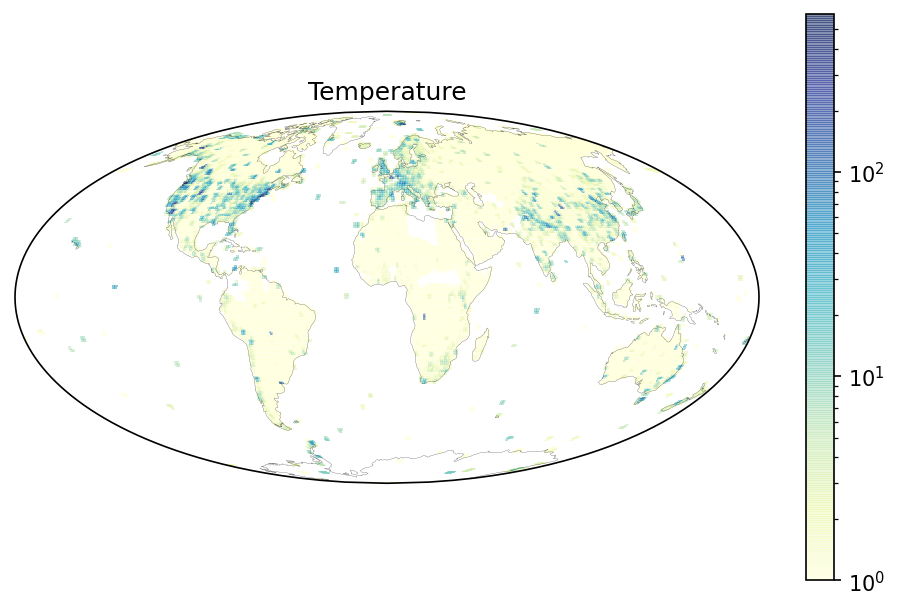

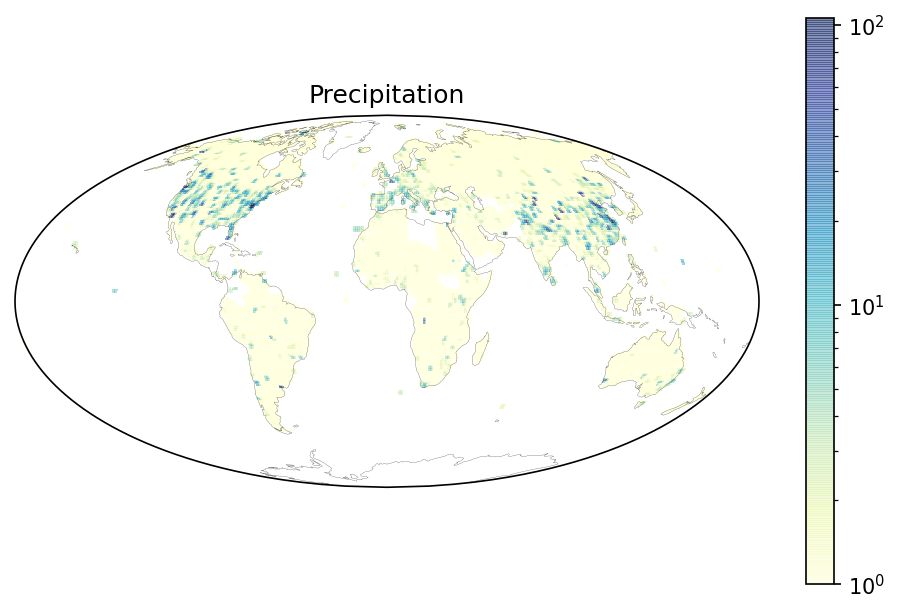

In [12]:
for c in driver_cats:
    fig, ax = plt.subplots(dpi=150, figsize=(8,5))

    sdf = df_places[df_places[c]>0.5]

    latbins, lonbins, n = density_grid(1,100,sdf)


    p = ccrs.Mollweide()
    #p = ccrs.PlateCarree()

    ax = plt.axes(projection=p)
    ax.set_global()
    ax.coastlines(lw=0.1)

    vm = n[~np.isnan(n)].max()

    n[n == 0] = np.nan

    pcm = plt.pcolormesh( 
        lonbins, latbins, n,
        transform=ccrs.PlateCarree(),
        norm=mpl.colors.LogNorm(vmin=1, vmax=vm),
        alpha=0.5,
        cmap="YlGnBu"
    )
    
    cname = c.split(' - ')[1].replace(" ","_")
    plt.savefig(f'../plots/maps/predicted_places_{cname}_density.png',dpi=500)
    plt.savefig(f'../plots/maps/predicted_places_{cname}_density.pdf')
    
    ax.set_title(cname)

    fig.colorbar(pcm)    


In [128]:
for name, group in df_places.groupby('feature_code'):
    print(name)
    print(len(group.doc_id.unique()))


579
ADM1
12413
ADM1H
77
ADM2
4907
ADM2H
5
ADM3
919
ADM3H
1
ADM4
320
ADM4H
1
ADM5
6
ADMD
327
ADMF
115
AGRC
3
AGRF
19
AIRB
7
AIRF
53
AIRH
15
AIRP
485
AIRQ
5
AIRS
1
AMUS
7
ANCH
2
ANS
73
ARCH
1
AREA
131
ATOL
51
BANK
1
BAR
202
BAY
499
BCH
17
BCN
15
BDG
39
BDLU
1
BGHT
2
BLDG
2734
BNK
1
BNKU
3
BOG
4
BRKS
2
BSND
1
BSNU
137
BUSTN
4
BUSTP
31
CAPE
176
CAPG
22
CDAU
33
CH
213
CHN
97
CHNM
12
CLF
4
CMP
66
CMPQ
23
CMTY
91
CNFL
7
CNL
74
CNLD
1
CNS
1
CNYN
2
CNYU
1
COMC
1
CONE
5
CONT
350
COVE
65
CRKT
15
CRNT
5
CRRL
1
CRTR
3
CSTL
1
CTRB
1
CTRCM
2
CTRM
3
CULT
4
DAM
263
DAMQ
1
DCK
4
DEVH
5
DIP
19
DLTA
52
DPR
112
DSRT
149
DTCH
3
ESCU
11
EST
28
ESTO
1
ESTR
6
ESTY
22
FCL
8
FJD
38
FLLS
8
FLTT
1
FORD
4
FRM
159
FRMQ
2
FRMT
3
FRST
35
FT
5
FY
1
GAP
1
GASF
1
GLCR
156
GOVL
3
GRAZ
14
GRSLD
1
GULF
87
HBR
19
HBRX
1
HDLD
3
HLL
107
HLLS
20
HLLU
1
HLT
1
HMSD
27
HSE
11
HSP
121
HSPC
5
HSTS
22
HTL
2736
HUT
2
INDS
3
INLT
23
INSM
12
ISL
1590
ISLET
3
ISLS
377
ISLX
3
ITTR
28
KNLU
1
LAND
443
LAVA
2
LBED
1
LCTY
47
LEV
1
LGN
24
LGN

calculating density grid of size: 64800
done


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


calculating density grid of size: 64800
done


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


calculating density grid of size: 64800
done


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


calculating density grid of size: 64800
done


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


calculating density grid of size: 64800
done


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


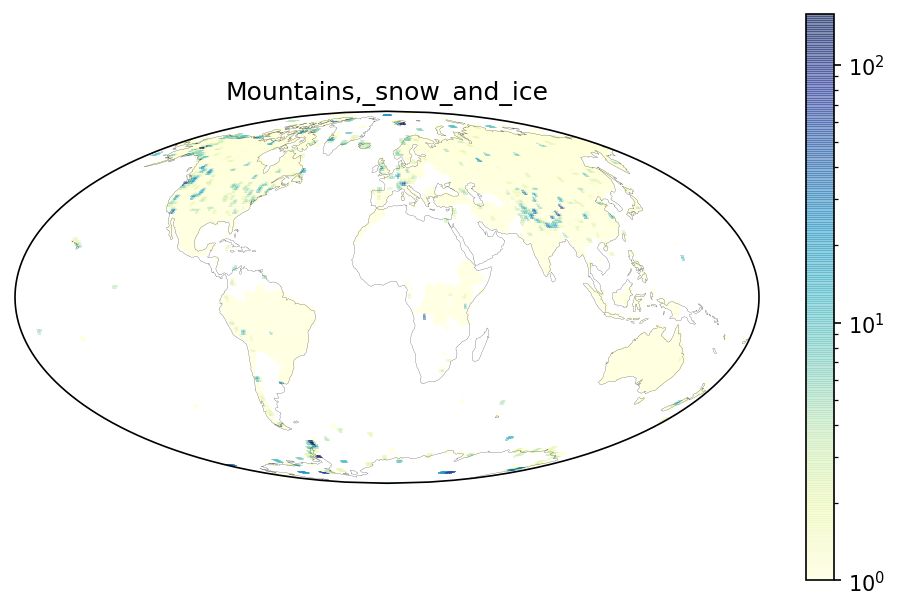

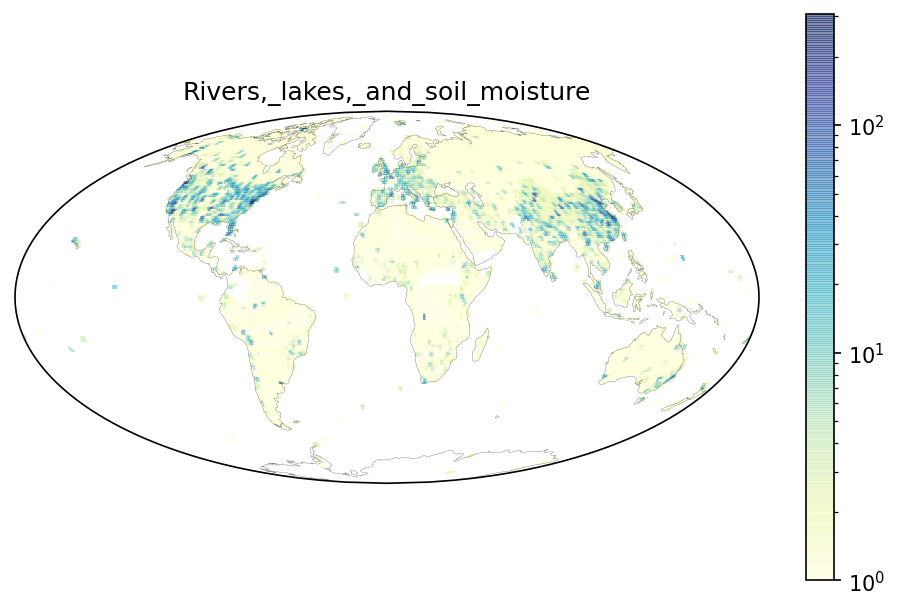

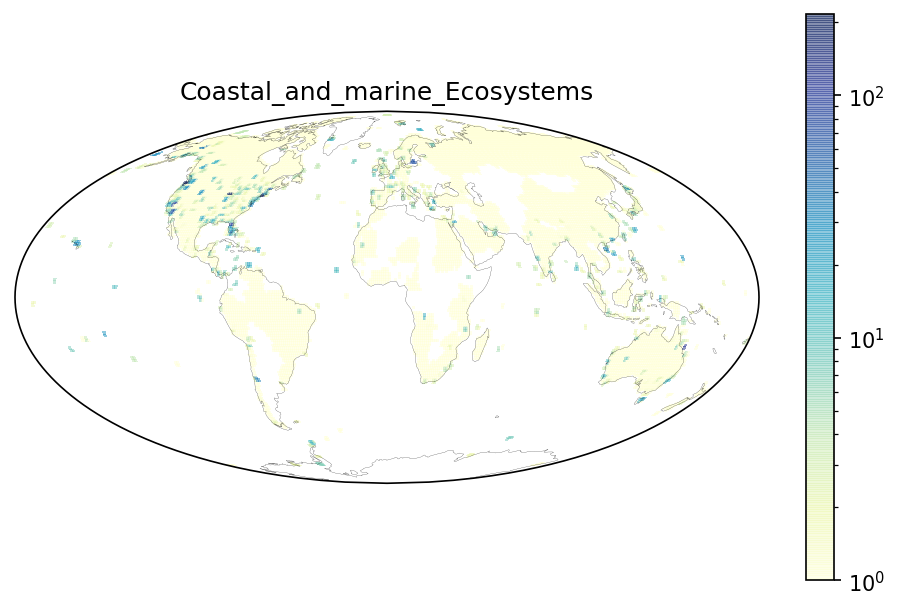

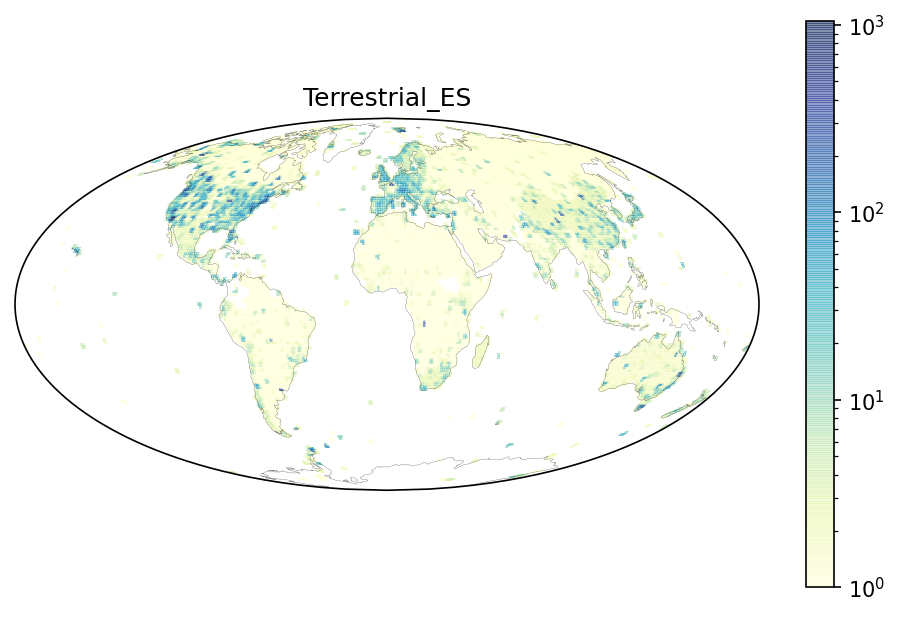

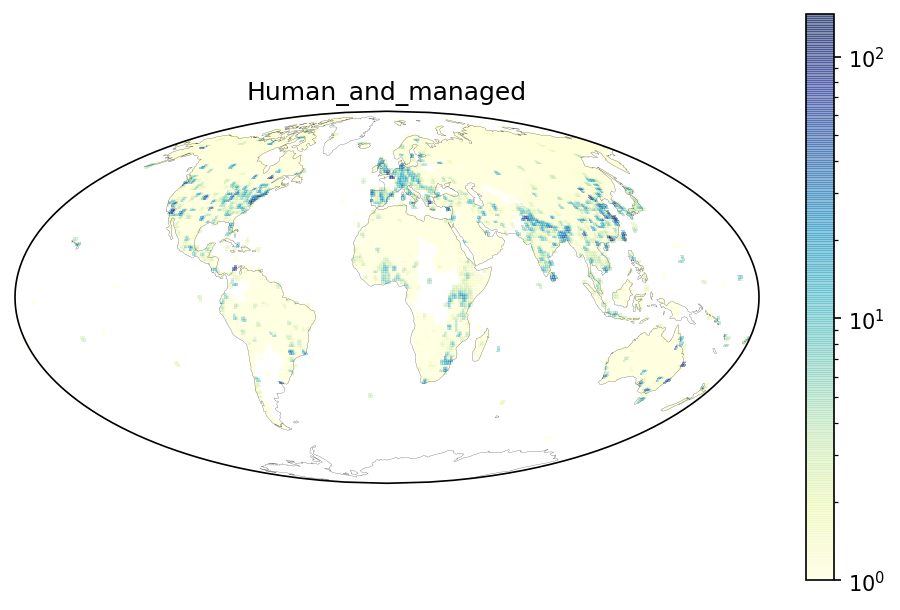

In [13]:
for c in pred_cats:
    fig, ax = plt.subplots(dpi=150, figsize=(8,5))

    sdf = df_places[df_places[c]>0.5]

    latbins, lonbins, n = density_grid(1,100,sdf)


    p = ccrs.Mollweide()
    #p = ccrs.PlateCarree()

    ax = plt.axes(projection=p)
    ax.set_global()
    ax.coastlines(lw=0.1)

    vm = n[~np.isnan(n)].max()

    n[n == 0] = np.nan

    pcm = plt.pcolormesh( 
        lonbins, latbins, n,
        transform=ccrs.PlateCarree(),
        norm=mpl.colors.LogNorm(vmin=1, vmax=vm),
        alpha=0.5,
        cmap="YlGnBu"
    )
    
    cname = c.split(' - ')[1].replace(" ","_")
    plt.savefig(f'../plots/maps/predicted_places_{cname}_density.png',dpi=500)
    plt.savefig(f'../plots/maps/predicted_places_{cname}_density.pdf')
    
    ax.set_title(cname)

    fig.colorbar(pcm)    

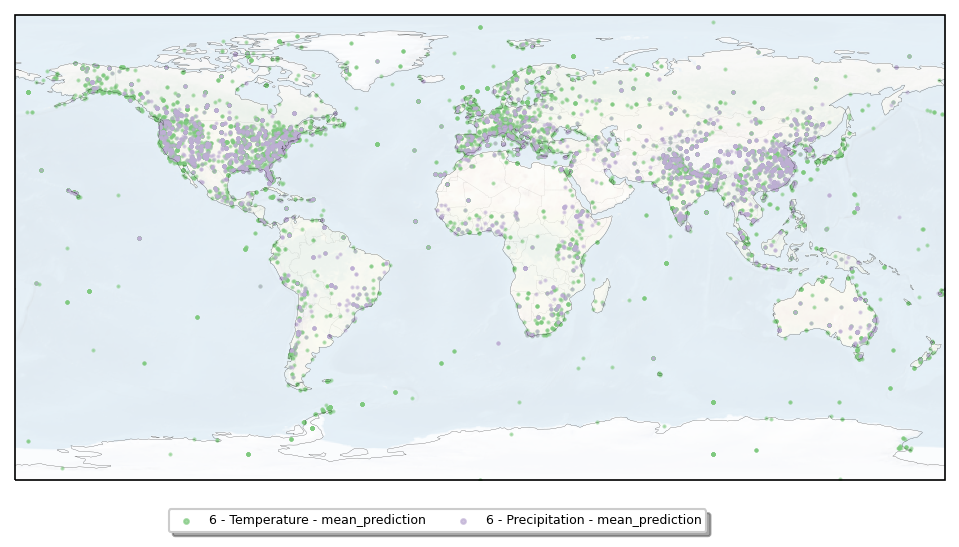

In [16]:
pred_cats = [c for c  in df.columns if "12 - " in c and " - prediction" in c]

colors = ['#7fc97f','#beaed4','#fdc086']

pdf = df_places[df_places['feature_code']!="PCLI"]

fig, ax = plt.subplots(dpi=150, figsize=(8,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(lw=0.1)
ax.stock_img(alpha=0.2)
ax.set_global()
ax.add_feature(cartopy.feature.BORDERS, linestyle=':',lw=0.05)

for i,c in enumerate(driver_cats):
    col = colors[i]
    ax.scatter(pdf[pdf[c]>=0.5]['lon'], pdf[pdf[c]>=0.5]['lat'],alpha=0.5,s=1,label=None,c=col)
    ax.scatter([],[],alpha=0.7,s=5,label=c,c=col)

    
ax.legend(fontsize=6, bbox_to_anchor=(0.75,-0.05),ncol=2, fancybox=True,shadow=True)

plt.savefig(f'../plots/maps/predicted_places_drivers_attribution.png',dpi=500)
plt.savefig(f'../plots/maps/predicted_places_drivers_attribution.pdf')

In [ ]:
pred_cats = [c for c  in df.columns if "12 - " in c and " - prediction" in c]

colors = ['#7fc97f','#beaed4','#fdc086']

pdf = df_geo[df_geo['feature_code']!="PCLI"]

for i,c in enumerate(attrib_cats):
    fig, ax = plt.subplots(dpi=150, figsize=(8,5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(lw=0.1)
    ax.stock_img(alpha=0.2)
    ax.set_global()
    ax.set_title(c)
    col = colors[i]
    ax.scatter(pdf[pdf[c]>=0.5]['lon'], pdf[pdf[c]>=0.5]['lat'],alpha=0.2,s=1,label=None,c=col)

    
ax.legend(fontsize=6)

In [ ]:
pred_cats = [c for c  in df.columns if "12 - " in c and " - prediction" in c]
fig, ax = plt.subplots(dpi=150, figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(lw=0.1)
ax.stock_img(alpha=0.5)
ax.set_global()
colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3']
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']
for j, pdf in enumerate(np.array_split(df_geo,5)):
    for i,c in enumerate(pred_cats):
        #pdf = pdf[pdf[c]>0.5]
        col = colors[i]
        ax.scatter(pdf[pdf[c]>0.5]['lon'], pdf[pdf[c]>0.5]['lat'],alpha=0.05,s=0.5,label=None,c=col)
        if j==0:
            ax.scatter([],[],alpha=0.5,label=c,c=col)
    
ax.legend(fontsize=6)

In [ ]:
pred_cats = [c for c  in df.columns if "12 - " in c and "mean" in c]
colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3']
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']

pdf = df_geo[df_geo['feature_code']!="PCLI"]

for i,c in enumerate(pred_cats):
    fig, ax = plt.subplots(dpi=150, figsize=(8,5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(lw=0.1)
    ax.stock_img(alpha=0.5)
    ax.set_global()
    ax.set_title(c)
    col = colors[i]
    ax.scatter(pdf[pdf[c]>0.5]['lon'], pdf[pdf[c]>0.5]['lat'],alpha=0.2,s=1,label=None,c=col)
    if j==0:
        ax.scatter([],[],alpha=0.2,label=c,c=col)
    
ax.legend(fontsize=6)

In [ ]:
c.split(' - ')[1].replace("_","")

In [ ]:
colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3']
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']
colors = ['#7fc97f','#beaed4','#fdc086']
pdf = df_geo[df_geo['feature_code']!="PCLI"]
import cartopy

for i,c in enumerate(pred_cats):
    fig, ax = plt.subplots(dpi=150, figsize=(8,5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(lw=0.1)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':',lw=0.05)
    ax.stock_img(alpha=0.2)
    ax.set_global()
    ax.set_title(c)
    for j, ac in enumerate(attrib_cats):
        col = colors[j]
        ax.scatter(
            pdf[(pdf[c]>=0.5)&(pdf[ac]>0.5)]['lon'], pdf[(pdf[c]>=0.5)&(pdf[ac]>0.5)]['lat'],
            alpha=0.5,s=2,label=None,c=col,edgecolor="grey",linewidth=0.5)
        ax.scatter([],[],alpha=0.5,label=ac,c=col)
    
    ax.legend(fontsize=6, bbox_to_anchor=(1,-0.05),ncol=2, fancybox=True,shadow=True)
    cname = c.split(' - ')[1].replace(" ","_")
    plt.savefig(f'../plots/maps/predicted_places_{cname}_attribution.png',dpi=500)
    plt.savefig(f'../plots/maps/predicted_places_{cname}_attribution.pdf')

In [ ]:
us_coastal = df_geo[
    (df_geo['12 - Coastal and marine Ecosystems - prediction']==1) &
    (df_geo['lat']<51) &
    (df_geo['lat']>34) &
    (df_geo['lon']>-117) &
    (df_geo['lon']<-84)
]
us_coastal.shape
for i, row in us_coastal.groupby('geonameid'):
    if row.shape[0]<2:
        continue
    print(row['title'])
    print(row['place_name'])
    print(row['id'])

In [ ]:

for i, row in df_places[df_places['id']==265589].reset_index(drop=True).iterrows():
    if i==0:
        print(row['content'])
    print("word in text: ",row['word'])
    print(row['geo'])
    print(row['country_predicted'])